# Universal Differential Equations (UDEs): training and symbolic regression to identify missing ODE terms

This tutorial demonstrates how one can Collimator to learn Universal Differential Equations (UDEs)---differential equations that are either fully or partly defined by a universal approximator such as a neural network. UDEs that are fully defined by a neural network are often known as neural differential equations.

As in [1], we demonstrate how the Lotka-Volterra system can be learned as a UDE from data obtained over a short duration. Subsequently, the UDE can be symbolically regressed over to find an analytical representation of the UDE terma. This system can then be used to reliably predict longer term behaviour.

### Lotka-Volterra system
The Lotka-Volterra system, also known as the predator-prey equations, comprises a pair of first-order, nonlinear, differential equations frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The system equations are given by:

$$\frac{dx}{dt} = \alpha x - \beta xy,$$
$$\frac{dy}{dt} = \gamma xy - \delta y,$$

where:
- $x$ represents the number of prey (for example, rabbits),
- $y$ represents the number of predators (for example, foxes),
- $\frac{dx}{dt}$ and $\frac{dy}{dt}$ represent the growth rates of prey and predator populations over time, respectively,
- $\alpha$, $\beta$, $\delta$, and $\gamma$ are positive real constants that represent the interaction rates between the species and their environment. Specifically, $\alpha$ is the natural growth rate of prey in the absence of predators, $\beta$ is the mortality rate of prey due to predation, $\delta$ is the natural death rate of predators in the absence of prey, and $\gamma$ represents the growth rate of the predator population per prey consumed.

These equations produce oscillations in the populations of both species, with the number of prey increasing when predators are scarce, followed by an increase in the number of predators as there is more prey to consume. This, in turn, leads to a decrease in the prey population due to predation, and subsequently, a decrease in the predator population as food becomes scarce. These cyclic dynamics are observed in many real-world predator-prey systems and provide insights into the complexity of ecological interactions and the importance of biodiversity for ecosystem stability.

### Steps in this notebook

We will follow the following steps in this notebook:

1. Create and simulate the Lotka-Volterra system in Collimator with known parameters. We will simulate the system for a short duration and a long duration to generate true data. We will treat the short duration data after adding noise as experimentally obtained data for training. The longer duration data will be used for testing.
2. We will assume that only the linear terms in the Lotka-Volterra system are known *a priori*. For the missing dynamics we will use a neural network. Thus, our UDE will be of the following form:
   $$\frac{dx}{dt} = \alpha x - f_{\theta}[0],$$
   $$\frac{dy}{dt} = -\delta y - f_{\theta}[1],$$
   where $f_{\theta}$ represents a neural network with parameters $\theta$. We will use a multilayer perceptron (MLP) for the neural netowrk.
3. We will train $f_{\theta}$ on the short duration training data.
4. Finally, we will use symbolic regression to recover analytical expressions that represent $f_{\theta}$ and use this learned model for prediction.

The reader is reffered to [1] for more details of the adopted methodology.

[1] Rackauckas, C., Ma, Y., Martensen, J., Warner, C., Zubov, K., Supekar, R., Skinner, D., Ramadhan, A. and Edelman, A., 2020. Universal differential equations for scientific machine learning. [arXiv preprint arXiv:2001.04385.](https://arxiv.org/pdf/2001.04385.pdf)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from functools import partial
from scipy.optimize import minimize

import jax
import jax.random as jr
import jax.numpy as jnp

import equinox as eqx
import optax

import collimator
from collimator.framework import LeafSystem
from collimator.simulation import SimulatorOptions, ResultsOptions

from collimator import logging
logging.set_log_level(logging.ERROR)

from collimator.library import MLP, Adder, Integrator, Power, Clock, FeedthroughBlock, SourceBlock

## Create a Collimator LeafSystem for true Lotka-Volterra system

The code-block below implements the true Lotka-Volterra system dynamics.

In [2]:
class LotkaVolterra(LeafSystem):
    ''' True Lotka Volterra system '''
    def __init__(self, u0=[10.0, 10.0], alpha=1.3, beta=0.9, gamma=0.8, delta=1.8, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.declare_dynamic_parameter("alpha", alpha)
        self.declare_dynamic_parameter("beta", beta)
        self.declare_dynamic_parameter("gamma", gamma)
        self.declare_dynamic_parameter("delta", delta)

        # Continuous state u = [x, y]
        self.declare_continuous_state(default_value=jnp.array(u0), ode=self.ode)

        # Output the full state [x,y] from the block
        self.declare_continuous_state_output()

    def ode(self, time, state, *inputs, **parameters):
        # Unpack state
        x, y = state.continuous_state

        # Gather parameters
        alpha = parameters["alpha"]
        beta = parameters["beta"]
        gamma = parameters["gamma"]
        delta = parameters["delta"]

        # Implement the ODE RHS for the Lotka-Volterra system
        dot_x = alpha * x - beta * x * y
        dot_y = gamma * x * y - delta * y
        return jnp.array([dot_x, dot_y])

## Simulate the system for short and long durations
We implement *Scenario-1* from reference [1].

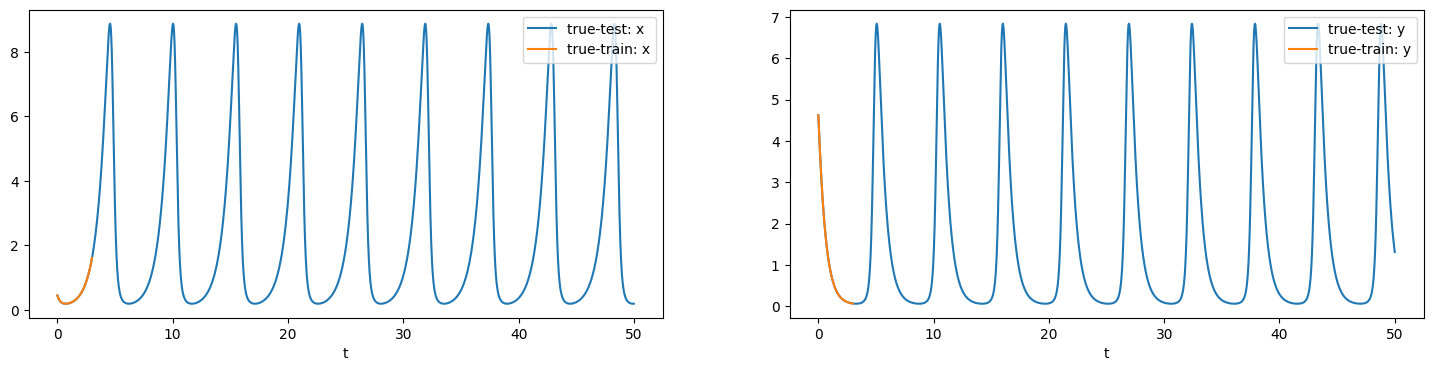

In [3]:
T_short = 3.0
T_long = 50.0

u0 = [0.44249296, 4.6280594] # initial state

params = [1.3, 0.9, 0.8, 1.8] # True parameters

def plot_sol(sols, labels=None):
    ''' Utiliity to plot multiple Simulation results objects '''
    if labels is None:
        labels = [f"sol-{i}" for i in range(len(sols))]

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=[18,4])
    for sol, label in zip(sols, labels):
        ax1.plot(sol.time, sol.outputs["u"][:,0], label = label + ": x")
        ax2.plot(sol.time, sol.outputs["u"][:,1], label = label + ": y")
        for ax in (ax1, ax2):
            ax.legend(loc="upper right")
            ax.set_xlabel("t")
    plt.show()

def make_true_sys():
    ''' Create diagam with just the Lotka-Volterra block '''
    builder = collimator.DiagramBuilder()
    lv = builder.add(LotkaVolterra(u0, *params, name="lv"))
    diagram = builder.build()
    return diagram

def run_true_sys(tspan):
    ''' Utility to run the true system for a given time span '''
    diagram = make_true_sys()
    context = diagram.create_context()

    options = SimulatorOptions(max_minor_step_size=0.1, rtol=1e-12, atol=1e-12)
    recorded_signals = {"u": diagram["lv"].output_ports[0]}

    sol = collimator.simulate(diagram, context, tspan, options=options, recorded_signals=recorded_signals)

    return sol

sol_true_short = run_true_sys([0.0, T_short])
sol_true_long = run_true_sys([0.0, T_long])
plot_sol([sol_true_long, sol_true_short], ["true-test", "true-train"])

## Generate training data by adding noise to the short duration simulation output

In [4]:
sol = sol_true_short

# sample the solution at regular intervals
t_train = jnp.linspace(0.0, T_short, 31)

vec_interp = jax.vmap(jax.numpy.interp, in_axes=(None, None, 1), out_axes=1)
u_true = vec_interp(t_train, sol.time, sol.outputs["u"])

u_mean = jnp.mean(u_true, axis=0)

# Generate and add noise

noise_magnitude = 5e-3
noise_shape = u_true.shape

key = jr.PRNGKey(42)
key, noise_key = jr.split(key)
noise = u_mean * noise_magnitude * jr.normal(noise_key, noise_shape)

u_train = u_true + noise

## Create the UDE structure

To create the following UDE structure

   $$\frac{dx}{dt} = \alpha x - f_{\theta}[0],$$
   $$\frac{dy}{dt} = -\delta y - f_{\theta}[1],$$

we will represent the terms $[\alpha x, -\delta y]$ in a `FeedthroughBlock` and the $f_{\theta}$ as an `MLP` block. Subsequently, we can use the `Adder` block to sum the outputs, providing us the RHS of the UDE. This RHS can then be passed to an `Integrator` block to solve the UDE.

For training the UDE, it will also be useful for us to read the training data and compute the loss during the simulation. The instantaneous error $\mathbf{e}$ is the difference between the training data at time $t$ and the simulated output of the ODE, $\mathbf{e} = \mathbf{u}_{\text{train}} - \mathbf{u}_{\text{ude}}$. To obtain the cumulative loss during the entire training duration, we can integrate the instantaneous error to give us a loss $\mathcal{L} = \int_0^T \mathbf{e^T Q\; e} \, dt$, where $\mathbf{Q}$ is a positive definite matrix (we will choose Identity matrix). Thus, we add blocks to also compute this integral as part of our simulation run. The overall structure of the block diagrams is shown in the schematic below followed by implementation in code.

<img src="../media/LotkaVolterra_UDE.png" alt="UDE block diagram" width=800px/>

In [5]:
class KnownLotkaVolterraRHS(LeafSystem):
    ''' Known terms of the Lotka-Volterra system as a Feedthrough system'''
    def __init__(self, alpha=1.3, delta=1.8, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.declare_dynamic_parameter("alpha", alpha)
        self.declare_dynamic_parameter("delta", delta)

        self.declare_input_port()
        self.declare_output_port(self.rhs, default_value=jnp.zeros(2))

    def rhs(self, time, state, inputs, **parameters):
        x, y = inputs
        alpha = parameters["alpha"]
        delta = parameters["delta"]
        return jnp.array([alpha * x, - delta * y])

class InterpTrainingData(SourceBlock):
    ''' Block to interpolate the training data and output the interpolated
    values at the input time `t`
    '''
    def __init__(self, t_vec, x_arr, **kwargs):
        self.t_vec = t_vec
        self.x_arr = x_arr
        self.interp_fun = jax.vmap(jnp.interp, (None, None, 1))
        super().__init__(
            lambda t: self.interp_fun(t, self.t_vec, self.x_arr), **kwargs
        )

class LossStructure(FeedthroughBlock):
    ''' Quadratc prdocut of the error as loss '''
    def __init__(self, Q, *args, **kwargs):
        super().__init__(lambda e: e.T @ Q @ e, *args, **kwargs)

def make_ude_system():
    builder = collimator.DiagramBuilder()

    # the ude system
    klv_rhs = builder.add(KnownLotkaVolterraRHS(name="klv_rhs"))
    mlp = builder.add(MLP(2,2,5,3, seed=42, activation_str="rbf", name="mlp"))
    rhs = builder.add(Adder(2, name="rhs"))
    lv = builder.add(Integrator(u0, name="lv"))

    builder.connect(klv_rhs.output_ports[0], rhs.input_ports[0])
    builder.connect(mlp.output_ports[0], rhs.input_ports[1])
    builder.connect(rhs.output_ports[0], lv.input_ports[0])

    builder.connect(lv.output_ports[0], klv_rhs.input_ports[0])
    builder.connect(lv.output_ports[0], mlp.input_ports[0])

    # add extra components to compute cost/loss during simulation
    ref = builder.add(InterpTrainingData(t_train, u_train, name="ref"))
    err = builder.add(Adder(2, operators="+-", name="err"))
    cost = builder.add(LossStructure(jnp.eye(2), name="cost"))
    int_cost = builder.add(Integrator(0.0, name="int_cost"))

    builder.connect(ref.output_ports[0], err.input_ports[0])
    builder.connect(lv.output_ports[0], err.input_ports[1])
    builder.connect(err.output_ports[0], cost.input_ports[0])
    builder.connect(cost.output_ports[0], int_cost.input_ports[0])

    diagram = builder.build()
    return diagram

diagram = make_ude_system()
base_context = diagram.create_context()

The parameters of the MLP are of interest as these will be optimized to fit the training data. In the code below, we first extract the initial MLP parameters, which inherently have a PyTree structure. Then, we flatten this Pytree while also generating and `unflatten` function.

In [6]:
# Initial parameters
initial_mlp_parameters = base_context[diagram["mlp"].system_id].parameters["mlp_params"] # or alternatively, eqx.partition(diagram["mlp"].mlp, eqx.is_array)
initial_mlp_parameters_flat, unflatten = jax.flatten_util.ravel_pytree(initial_mlp_parameters)

Next, we create an `evaluate_model` function, which given a set of flat MLP parameters, can return the computed loss. This is the loss term that we would like to minimize during UDE training.

In [7]:
options = SimulatorOptions(max_minor_step_size=0.1, max_major_steps=1000, rtol=1e-12, atol=1e-12, enable_autodiff=True)

# generate a function to evaluate the model from flat parameters because, unlike optax, scipy and jax.scipy optimization methods don't support pytrees.
def evaluate_model(mlp_params_flat, diagram, base_context):
    mlp_params = unflatten(mlp_params_flat)
    mlp_subcontext = base_context[diagram["mlp"].system_id].with_parameter("mlp_params", mlp_params)
    context = base_context.with_subcontext(diagram["mlp"].system_id, mlp_subcontext)
    sol = collimator.simulate(diagram, context, (0.0,T_short), options=options)
    return sol.context[diagram["int_cost"].system_id].continuous_state

### Automatic differentiation

We can now take advantage of JAX's JIT compilation and automatic differentiation capabilities to compute the gradient of the loss with respect to the MLP parameters.

In [8]:
loss = jax.jit(partial(evaluate_model, diagram=diagram, base_context=base_context))
value_and_grad = jax.jit(jax.value_and_grad(loss))

v,g = value_and_grad(initial_mlp_parameters_flat)
print("gradient shape:", g.shape)

gradient shape: (87,)


## UDE training

We now have all the machinery to train the UDE. As in [1], we first run the ADAM optimizer for a small number (200) of iterations to get a good guess. Subsequently, we use the BFGS optimizer, while starting from the solution of the ADAM optimizer.

### First run ADAM for 200 iteration to get a good guess for BFGS

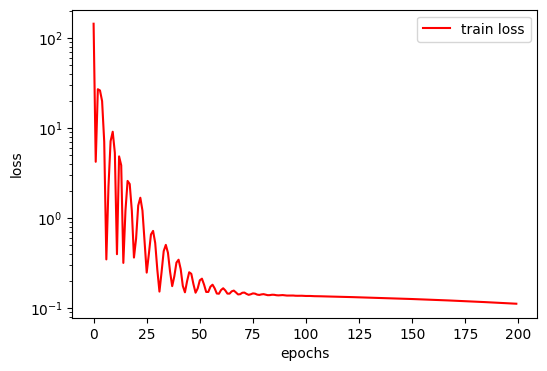

In [9]:
num_epochs = 200

# Optax optimizer
optimizer = optax.adam(learning_rate=0.1)

# Initialize optimizer state
params = initial_mlp_parameters_flat
opt_state = optimizer.init(params)

train_loss_history = []
for epoch in range(num_epochs):
    train_loss, grads = value_and_grad(params)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    train_loss_history.append(train_loss)

    # Print the function value at the current parameters
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}]: loss = {train_loss}"
        )

opt_params_adam = params
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(train_loss_history, "-r", label="train loss")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_yscale("log")
ax.legend()
plt.show()

### Run BFGS

In [10]:
opt_res = minimize(
    loss,
    opt_params_adam,
    jac = jax.jit(jax.grad(loss)),
    method="BFGS",
    options={"maxiter": 10000}
)

opt_params_flat = opt_res.x
opt_params = unflatten(opt_params_flat)

In [11]:
opt_res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 5.202838652783408e-05
        x: [ 2.173e-01  1.370e-01 ...  1.476e-01 -2.135e-01]
      nit: 323
      jac: [-1.101e-03 -1.209e-02 ...  2.132e-03 -1.040e-04]
 hess_inv: [[ 2.647e+02 -5.243e+01 ...  1.967e+02 -3.277e+02]
            [-5.243e+01  1.438e+01 ... -5.530e+01  8.677e+01]
            ...
            [ 1.967e+02 -5.530e+01 ...  2.272e+02 -3.525e+02]
            [-3.277e+02  8.677e+01 ... -3.525e+02  5.954e+02]]
     nfev: 436
     njev: 424

## Visualise training and predictions from UDE alone

We now simulate the UDE system from the trained parameters.

In [12]:
def run_ude_sys(params, tspan):
    diagram = make_ude_system()
    base_context = diagram.create_context()
    mlp_subcontext = base_context[diagram["mlp"].system_id].with_parameter("mlp_params", params)
    context = base_context.with_subcontext(diagram["mlp"].system_id, mlp_subcontext)

    options = SimulatorOptions(max_minor_step_size=0.1, max_major_steps=1000, rtol=1e-12, atol=1e-12)
    recorded_signals = {
        "u": diagram["lv"].output_ports[0],
        "mlp": diagram["mlp"].output_ports[0],
    }
    sol_ude = collimator.simulate(diagram, context, tspan, options=options, recorded_signals=recorded_signals)
    return sol_ude

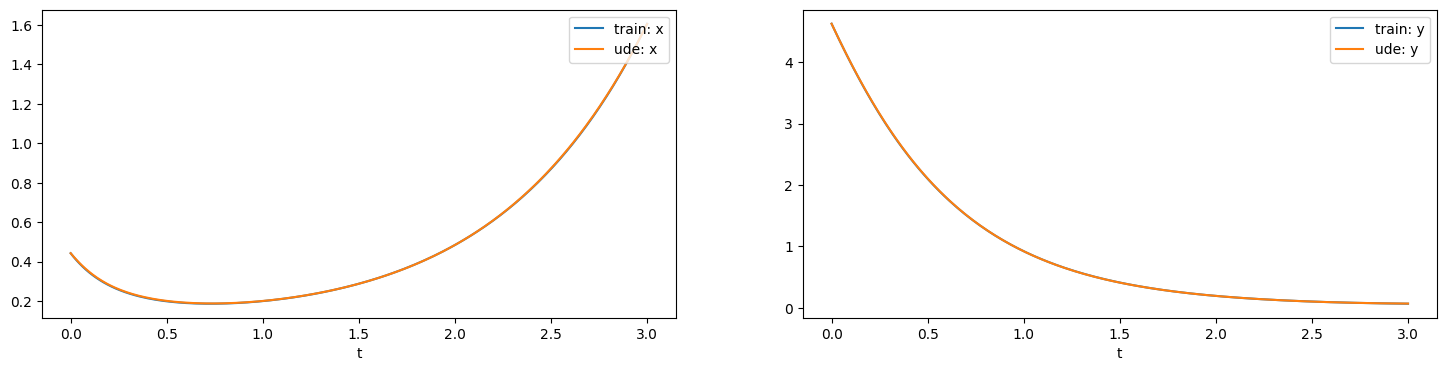

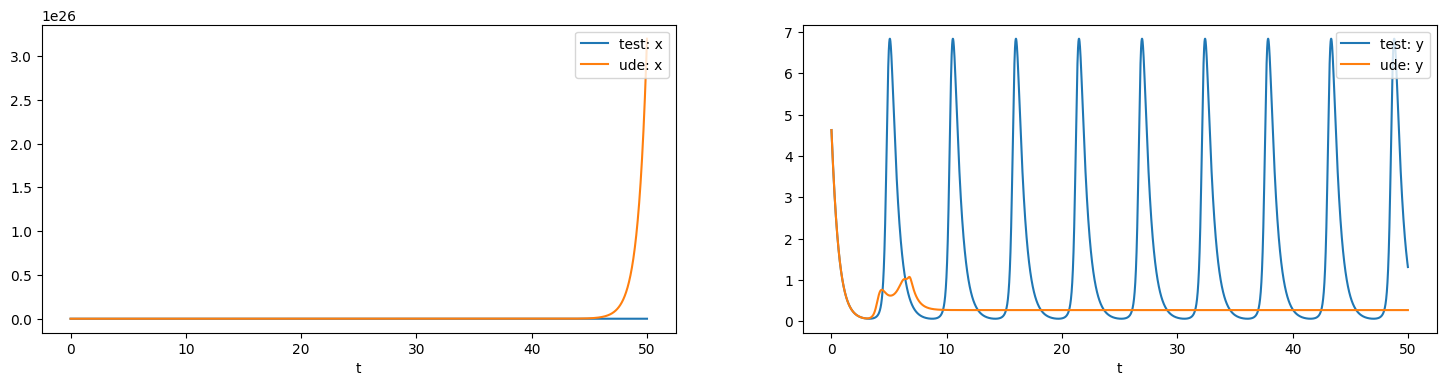

In [13]:
sol_ude_short = run_ude_sys(opt_params, (0.0, T_short))
sol_ude_long = run_ude_sys(opt_params, (0.0, T_long))

plot_sol([sol_true_short, sol_ude_short], ["train", "ude"])
plot_sol([sol_true_long, sol_ude_long], ["test", "ude"])

We find that the training data is reproduced very well. However, the UDE model quickly falls apart when predicting for durations beyong the training duration. It is wiser to use the UDE to learn the missing ODE terms, i.e. learn analytical expressions representing the trained neural netowork in the UDE. This is shown below.

## Symbolic regression to recover missing ODE terms

To obtain analytical expressions for the trained MLP, we can utilise Symbolic Regression. There are multiple choices for Symbolic Regression within the Python ecosystem. Below we demonstrate a few of these.

### Prepare data for symbolic regression

We directly use the data generated during the above training. However, it is also possible to sample from the MLP to get better training data for symbolic regression.

In [14]:
sol = sol_ude_short
mlp_in = sol.outputs["u"]
mlp_out = sol.outputs["mlp"]

The problem of symbolic regression is to learn analytical terms that would map `mlp_in` vector to the `mlp_out` vector.

### Use PySindy library for symbolic regression

To use PySindy for our purposes, we can can represent the derivaitives `x_dot` as the `mlp_out` vector and `x` as the `mlp_in` vector. PySindy will then perform symbolic regression mapping `x_dot` to `x`, thus achieving our objective.

In [15]:
import pysindy as ps

# Fit the model
poly_order = 2
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)

model.fit(mlp_in, x_dot=mlp_out)
model.print()

(x0)' = -0.886 x0 x1
(x1)' = 0.809 x0 x1


We find that the `pysindy` has recovered the missing terms from the learned UDE data. The same form of equations as the true Lotka-Volterra system is recovered with $\beta = 0.886$ and $\gamma=0.809$. Recall that the true values for both these parameters were 0.9 and 0.8, respectively. For better precision, we can looks at `model.coefficients`.

In [16]:
model.coefficients()

array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.88578619,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.80866836,
         0.        ]])

We can now simulate our learned system from the UDE approximation. Here, we replace the MLO with the analytical expressions we have found via symbolic regression.

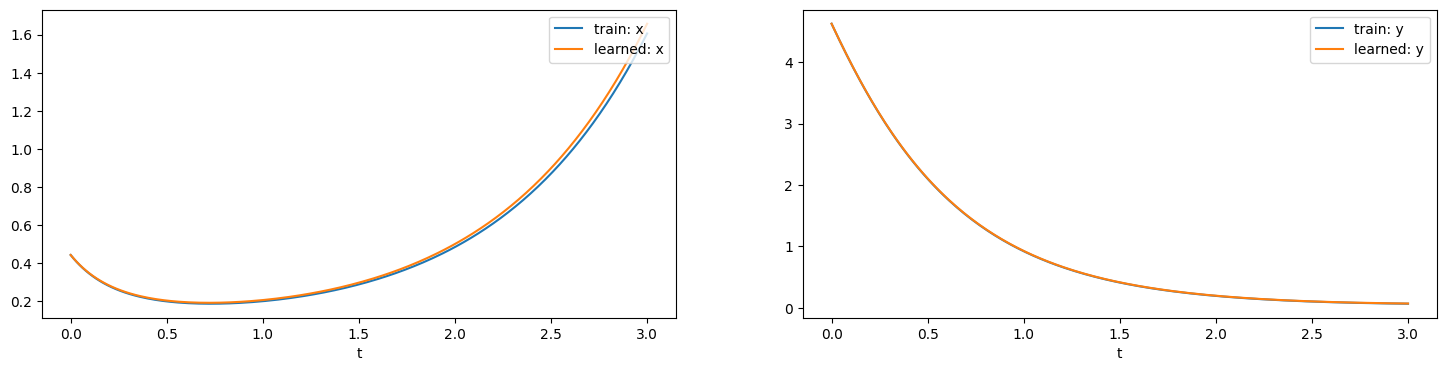

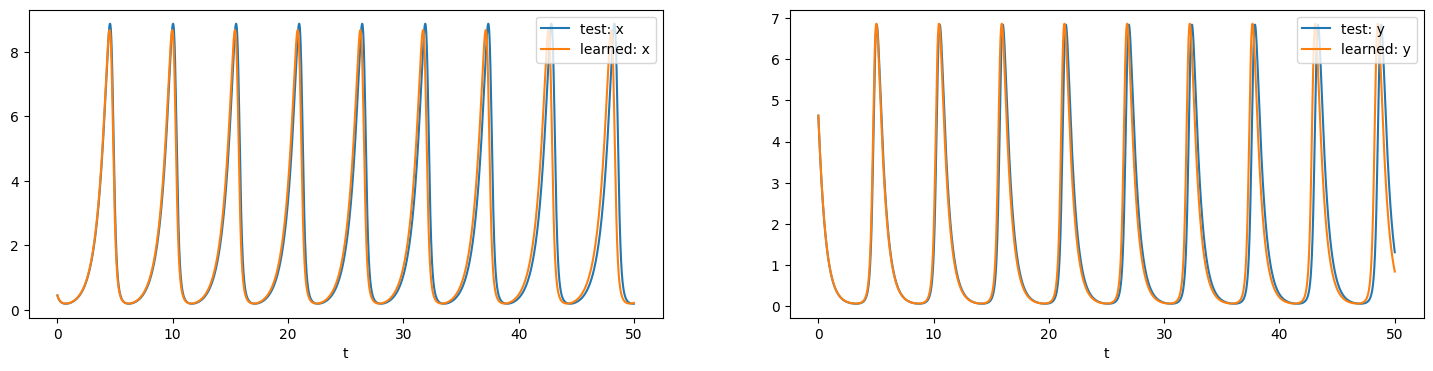

In [17]:
class LotkaVolterraLearned(LeafSystem):
    def __init__(self, u0=[10.0, 10.0], alpha=1.3, delta=1.8, c1=0.0, c2=0.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.delta = delta
        self.c1 = c1
        self.c2 = c2
        self.declare_continuous_state(default_value=jnp.array(u0), ode=self.ode)
        self.declare_continuous_state_output()

    def ode(self, time, state, *inputs, **parameters):
        x, y = state.continuous_state
        return jnp.array([(self.alpha * x - self.c1 * x * y), (self.c2 * x * y - self.delta * y)])

def make_learned_sys(c1, c2):
    builder = collimator.DiagramBuilder()
    lv = builder.add(LotkaVolterraLearned(u0, c1=c1, c2=c2, name="lv"))
    diagram = builder.build()
    return diagram

def run_learned_sys(tspan, c1, c2):
    diagram = make_learned_sys(c1, c2)
    context = diagram.create_context()

    options = SimulatorOptions(max_minor_step_size=0.1, rtol=1e-12, atol=1e-12)
    recorded_signals = {"u": diagram["lv"].output_ports[0]}

    sol = collimator.simulate(diagram, context, tspan, options=options, recorded_signals=recorded_signals)
    return sol

sol_learned_short = run_learned_sys([0.0, T_short], c1=0.88578619, c2=0.80866836)
sol_learned_long = run_learned_sys([0.0, T_long], c1=0.88578619, c2=0.80866836)

plot_sol([sol_true_short, sol_learned_short], ["train", "learned"])
plot_sol([sol_true_long, sol_learned_long], ["test", "learned"])

We obtain a good match for both short duration training data and the longer duration rest data.

### Use gplearn for symbolic regression

In [18]:
from gplearn.genetic import SymbolicRegressor

In [19]:
est_gp_1 = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp_1.fit(mlp_in, mlp_out[:,0])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          1239.73        7        0.0338484        0.0360894      1.35m
   1    11.76           3.1325       11        0.0102274        0.0104725     53.99s
   2     7.30          60.0469       11       0.00505558       0.00615958     48.02s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

Let's simplify the found symbolic regressor

In [20]:
print(est_gp_1._program)

div(X0, mul(div(-0.780, X1), div(-0.192, div(-0.045, 0.336))))


In [21]:
c1 = 0.045/0.780/0.192/0.336
print(c1)

0.8942880036630035


In [22]:
est_gp_2 = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp_2.fit(mlp_in, mlp_out[:,1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          1239.67        7        0.0391281        0.0436253      1.34m
   1    11.13          2.07201        7       0.00628566       0.00318857     53.68s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

Let's simplify the found symbolic regressor

In [23]:
print(est_gp_2._program)

mul(mul(0.400, X0), add(X1, X1))


In [24]:
c2 = 0.4*2
print(c2)

0.8


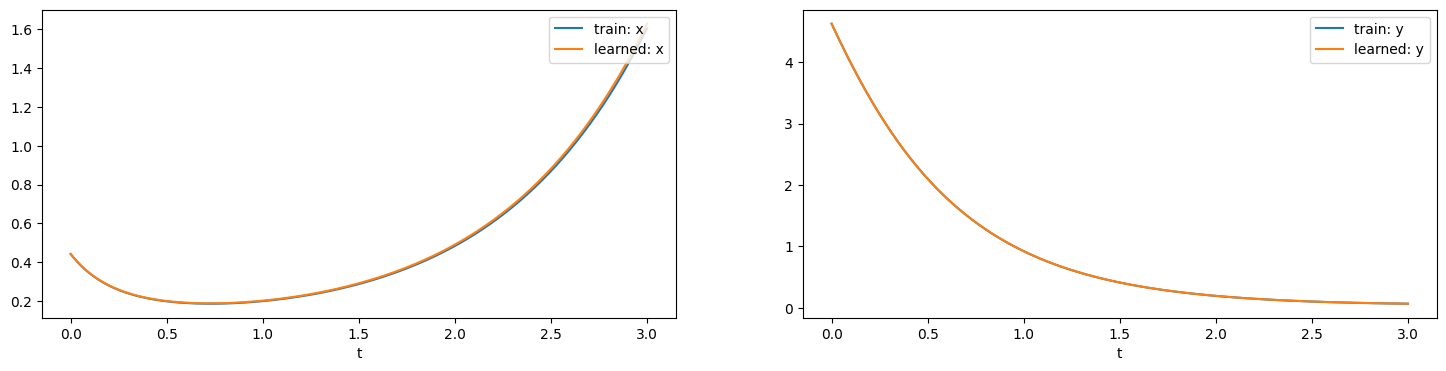

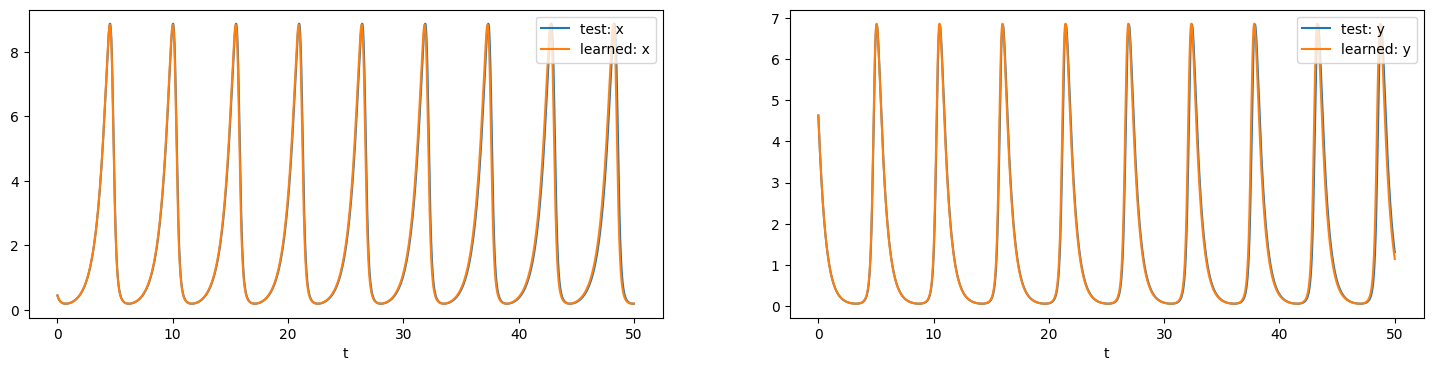

In [25]:
sol_learned_short = run_learned_sys([0.0, T_short], c1=c1, c2=c2)
sol_learned_long = run_learned_sys([0.0, T_long], c1=c1, c2=c2)

plot_sol([sol_true_short, sol_learned_short], ["train", "learned"])
plot_sol([sol_true_long, sol_learned_long], ["test", "learned"])

You may also wish to try other symbolic regression libraries such as PySR etc.